# 1. Подготовка данных

Первым шагом настроим окружение: импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

Сохраним в переменной data входные данные о заказах такси в аэропортах. Выведем первые 5 строк. Изменим тип данных Datetime с object на datetime64. Установим индекс таблицы равным столбцу Datetime. 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)

In [3]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположены даты и время. Вызовом функции info() выведим на экран общую информацию о таблице.

In [4]:
print(data.index.is_monotonic)

True


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


 Изменbм интервал временного ряда, выполним ресемплирование по одному часу.

In [6]:
data = data.resample('1H').sum()
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


# 2. Анализ

Построим график с суммарным количеством заказов такси в аэропорт за месяц.

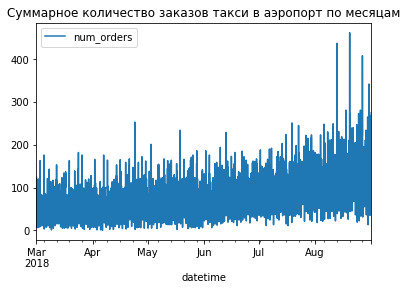

In [7]:
data.plot()
plt.title('Суммарное количество заказов такси в аэропорт по месяцам')
plt.show()

Разложим временной ряд на тренд и сезонную компоненту.

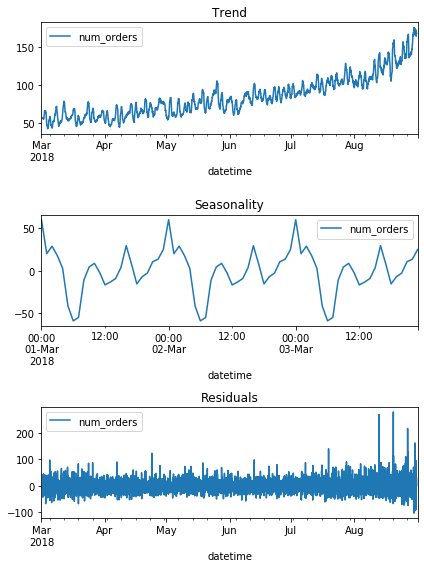

In [8]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca()) 

plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Наблюдается тренд увеличения количества заказов в такси в летние месяцы, что, по-видимому, связано с сезоном отпусков. Из этого можно сделать вывод о том, что временной ряд не является стационарнымю Сезонность указывает на пик суммарного количества заказов такси в ночное время, вероятной причиной является недоступность общественного транспорта в данное время суток.

# 3. Обучение

Создадим функцию make_features() для добавления в данных четыре новых календарных признака: год, месяц, день и день недели. В функцию make_features() добавим аргумент max_lag, который задаст максимальный размер отставания. При этом лаги будем брать начиная с 12, таким образом модель будет строить предсказания на основе данных за предыдущую половину дня. Добавим в таблицу признак скользящее среднее 'rolling_mean' с шириной окна rolling_mean_size.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(12, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Применим функцию к таблице данных. Установим максимальный размер отставания 24*7 часов, равным неделе наблюдений.

In [10]:
make_features(data, 168, 10)

In [11]:
display(data.head())

,num_orders,year,month,day,dayofweek,lag_12,lag_13,lag_14,lag_15,lag_16,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую, валидационную и тестовую выборки. Валидационную и тестовую выборки сделаем размером 10% каждая от исходных данных.

In [12]:
train, valid_test = train_test_split(data, shuffle=False, test_size = 0.2)

In [13]:
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

Выведем минимальные и максимальные значения индексов выборок, размеры выборок для проверки корректности деления данных.

In [14]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [15]:
print(train.shape)
print(valid.shape)
print(test.shape)

(3532, 163)
(442, 163)
(442, 163)


Удалим строки с пропусками из обучающей выборки.

In [16]:
train = train.dropna()

В каждой выборке выделим признаки и целевой признак.

In [17]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Для прогноза количества заказов такси в аэропорт рассмотрим модели линейной регрессии и градиентного бустинга LGBMRegressor. Обучим модели на тренировочной выборке и проверим их качество на валидационной с целью выбора оптимальных моделей.

#### 3.1. Модель линейной регрессии

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
predict_valid = model.predict(features_valid)

mse = mean_squared_error(target_valid, predict_valid)
print('RMSE модели:', mse**0.5)

RMSE модели: 28.080698990956993


#### 3.2. Модель градиентного бустинга LGBMRegressor

In [19]:
for est in range(100, 201, 100):
    for depth in range(1, 10, 2):
        model = lgb.LGBMRegressor(num_leaves= 31, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predict_valid = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predict_valid)
        print('RMSE модели при max_depth:', depth, 'n_estimators', est, 'составляет', mse**0.5)

RMSE модели при max_depth: 1 n_estimators 100 составляет 31.040145738072518
RMSE модели при max_depth: 3 n_estimators 100 составляет 29.98856020283449
RMSE модели при max_depth: 5 n_estimators 100 составляет 30.115419856915082
RMSE модели при max_depth: 7 n_estimators 100 составляет 29.79670371562485
RMSE модели при max_depth: 9 n_estimators 100 составляет 29.91396160603349
RMSE модели при max_depth: 1 n_estimators 200 составляет 30.35372261333736
RMSE модели при max_depth: 3 n_estimators 200 составляет 30.331076075682503
RMSE модели при max_depth: 5 n_estimators 200 составляет 30.235970520360233
RMSE модели при max_depth: 7 n_estimators 200 составляет 30.121233330258796
RMSE модели при max_depth: 9 n_estimators 200 составляет 30.040841007579406


# 4. Тестирование

Проверим качество моделей линейной регрессии и градиентного бустинга LGBMRegressor на тестовой выборке.

In [20]:
model = lgb.LGBMRegressor(num_leaves= 31, max_depth=7, n_estimators=100)
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
mse = mean_squared_error(target_test, predict_test)
print('RMSE модели:', mse**0.5)

RMSE модели: 45.267983296871016


In [21]:
model = LinearRegression()
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
mse = mean_squared_error(target_test, predict_test)
print('RMSE модели:', mse**0.5)

RMSE модели: 37.130957220111384


Проверим исследованные модели на адекватность. Спрогнозируем временные ряды без обучения. Определим метрику RMSE предсказания количество заказов такси: средним значением и предыдущим значением ряда.

In [22]:
pred_mean = np.ones(test.shape[0]) * target_train.mean()
mse_mean = mean_squared_error(target_test, pred_mean)
print("RMSE по среднему значению:", mse_mean**0.5)

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_valid.iloc[-1]
mse_previous = mean_squared_error(target_test, pred_previous)
print('RMSE по предыдущему значению ряда:', mse_previous**0.5)

RMSE по среднему значению: 86.92314455376122
RMSE по предыдущему значению ряда: 58.856486242815066


### Вывод:
Построена модель для прогнозирования количества заказов такси в аэропорт на основе исторических данных заказов. Для предсказания были выбраны модель градиентного бустинга LGBMRegressor и модель линейной регрессии. Значение метрики RMSE на тестовой выборке составляет для модели LGBMRegressor **~45.3**, для линейной регрессии - **~37.1**, что отвечает условиям задачи. Исследованные модели проверены на адекватность, значение RMSE для найденных моделей характеризуется меньшим значением по сравнению с прогнозом по среднему значению (**RMSE = ~86.9**) и по предыдещему значению ряда (**RMSE = ~58.9**).